# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-w7ealbh7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-w7ealbh7
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


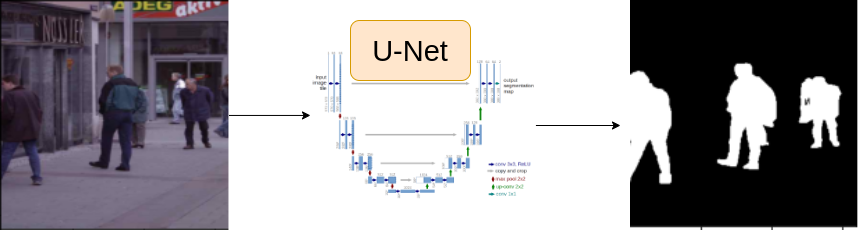

# Some Common Imports

In [3]:
import sys, os
sys.path.append(f'{os.getcwd()}/Human-Segmentation-Dataset-master')

In [4]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/Human-Segmentation-Dataset-master']

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [37]:
CSV_FILE = "./Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "./Human-Segmentation-Dataset-master/"

# DEVICE = "cuda"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 16
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [38]:
DEVICE

device(type='cuda')

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [9]:
row = df.iloc[5]
image_path, mask_path = row.images, row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

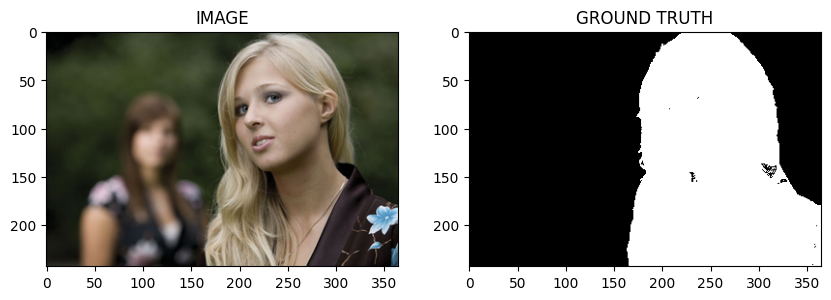

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image);

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray');

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2,
                                      random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
# Usefull for creating custom dataset
import albumentations as A

In [13]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ],
    is_check_shapes=False)

def get_valid_augs(): #
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ],
    is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [39]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path, mask_path = row.images, row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data["image"]
            mask = data["mask"]

        # pytorch uses (c, h, w) That's why (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.tensor(image) / 255.0
        mask = torch.round(torch.tensor(mask) / 255.0)

        return image, mask

In [40]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [41]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


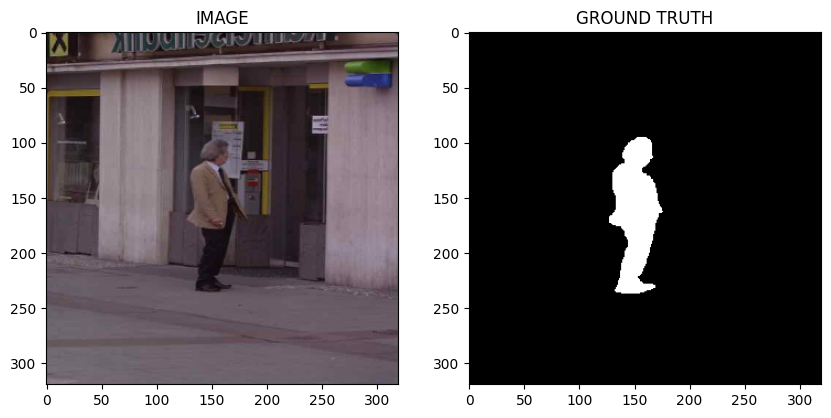

In [42]:
idx = 5
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [43]:
from torch.utils.data import DataLoader

In [44]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [45]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [46]:
for image, mask in trainloader:
    break
print("One batch image shape:", image.shape)
print("One batch mask shape:", mask.shape) # [batch_size, # of chanels, hight, width]

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [47]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [48]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels=3, # as we have RGB
            classes=1, # As it's binary segmentation problem
            activation=None # No activation (i.e sigmoid/Relu)
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)
        if masks!=None:
            loss1 = DiceLoss(mode="binary")(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1+loss2

        return logits # masks will be None Testing/Inference

In [49]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 15.8MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [50]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [51]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss/len(data_loader)

# Task 8 : Train Model

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [54]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved Model")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


Saved Model
Epoch : 1 Train_loss : 0.3741308659315109 Valid_loss : 0.39680586010217667


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch : 2 Train_loss : 0.3447597364584605 Valid_loss : 0.4054463282227516


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Saved Model
Epoch : 3 Train_loss : 0.26968040664990744 Valid_loss : 0.2635367810726166


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch : 4 Train_loss : 0.26647501985232036 Valid_loss : 0.28581206500530243


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Saved Model
Epoch : 5 Train_loss : 0.22414018313090006 Valid_loss : 0.20765560492873192


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Epoch : 6 Train_loss : 0.21723998387654622 Valid_loss : 0.25835755467414856


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Saved Model
Epoch : 7 Train_loss : 0.19674798448880512 Valid_loss : 0.20127297937870026


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Saved Model
Epoch : 8 Train_loss : 0.21196615050236384 Valid_loss : 0.1847928985953331


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch : 9 Train_loss : 0.18085383276144665 Valid_loss : 0.36637235432863235


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 10 Train_loss : 0.15794681708017985 Valid_loss : 0.2306799404323101


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Epoch : 11 Train_loss : 0.15253391315539677 Valid_loss : 0.1974514052271843


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 12 Train_loss : 0.13692024598519006 Valid_loss : 0.2013976238667965


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 13 Train_loss : 0.12997503827015558 Valid_loss : 0.20886782556772232


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch : 14 Train_loss : 0.11659959803024927 Valid_loss : 0.19391345977783203


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 15 Train_loss : 0.1403601030508677 Valid_loss : 0.25598761811852455


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch : 16 Train_loss : 0.13020483255386353 Valid_loss : 0.241242878139019


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 17 Train_loss : 0.14204359998305638 Valid_loss : 0.21861214563250542


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch : 18 Train_loss : 0.19064915875593821 Valid_loss : 0.23621966317296028


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


Epoch : 19 Train_loss : 0.17653659284114837 Valid_loss : 0.22458092495799065


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 20 Train_loss : 0.15608819474776586 Valid_loss : 0.2764645107090473


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch : 21 Train_loss : 0.14061883985996246 Valid_loss : 0.22490939125418663


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 22 Train_loss : 0.15072785764932634 Valid_loss : 0.219514861702919


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch : 23 Train_loss : 0.1429917484521866 Valid_loss : 0.2314427960664034


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


Epoch : 24 Train_loss : 0.1152858038743337 Valid_loss : 0.19396609626710415


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

Epoch : 25 Train_loss : 0.11183794140815735 Valid_loss : 0.1968439817428589


# Task 9 : Inference

In [58]:
idx = 10

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (l, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

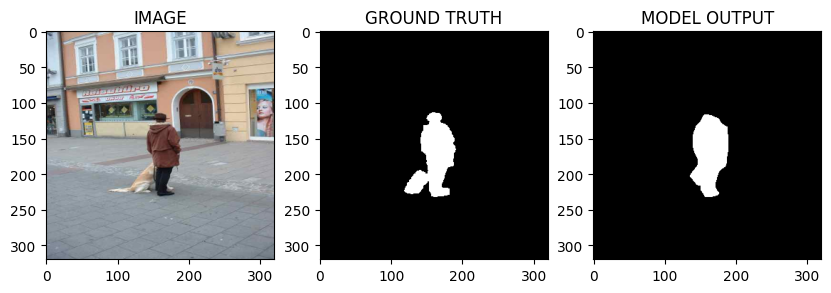

In [59]:
helper.show_image(image, mask, pred_mask.cpu().squeeze(0))